In [ ]:
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print("✅ Random seeds fixed for reproducibility")

✅ Random seeds fixed for reproducibility


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive"

'Colab Notebooks'   dataset  'Document from Girish NM.pdf'


In [ ]:
from google.colab import drive
import zipfile, os

import random
import os

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
# Mount Google Drive

# Path to zip file in Drive
zip_path = "/content/drive/MyDrive/dataset/dataset.zip"

# Path to extract in Colab
extract_path = "/content/dataset"

# Extract only if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("✅ Dataset extracted at:", extract_path)
print("📂 Classes:", os.listdir(extract_path))


✅ Dataset extracted at: /content/dataset
📂 Classes: ['dataset']


In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import pickle

In [ ]:
!pip install split-folders

In [ ]:
import os
import splitfolders  # after installing

# Path to dataset (your extracted folder with class subfolders)
DATA_DIR = "/content/dataset/dataset"

# Output path for train/val split
OUTPUT_DIR = "/content/output"

# Split only if output doesn't exist yet
if not os.path.exists(OUTPUT_DIR):
    splitfolders.ratio(DATA_DIR, output=OUTPUT_DIR, seed=1337, ratio=(0.8, 0.2))
    print("✅ Dataset split into train and val folders.")
else:
    print("⚠ Output folder already exists. Delete it if you want to re-split.")

Copying files: 4217 files [00:04, 920.83 files/s]

✅ Dataset split into train and val folders.


In [ ]:

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Validation data (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_gen = train_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
val_gen = val_datagen.flow_from_directory(
    os.path.join(OUTPUT_DIR, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Save class indices for later use (Flask app)
with open('class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)

print("✅ Class indices saved:", train_gen.class_indices)


Found 3372 images belonging to 4 classes.
Found 845 images belonging to 4 classes.
✅ Class indices saved: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extract labels from the training generator
labels = train_gen.classes   # numeric labels of each image in train set

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict {class_index: weight}
class_weights = dict(enumerate(class_weights))

print("✅ Class weights:",class_weights)

✅ Class weights: {0: np.float64(1.0156626506024096), 1: np.float64(0.9601366742596811), 2: np.float64(1.0472049689440994), 3: np.float64(0.9813736903376019)}


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze all layers except last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 7,211,780 (27.51 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_vgg19.h5', save_best_only=True, monitor='val_accuracy', mode='max',verbose=1)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stop,checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.3032 - loss: 1.4782
Epoch 1: val_accuracy improved from -inf to 0.67811, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 763ms/step - accuracy: 0.3036 - loss: 1.4770 - val_accuracy: 0.6781 - val_loss: 0.9646 - learning_rate: 1.0000e-05
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.5710 - loss: 0.9896
Epoch 2: val_accuracy improved from 0.67811 to 0.68521, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 80s 758ms/step - accuracy: 0.5713 - loss: 0.9890 - val_accuracy: 0.6852 - val_loss: 0.7803 - learning_rate: 1.0000e-05
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.6652 - loss: 0.8047
Epoch 3: val_accuracy improved from 0.68521 to 0.71006, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 80s 756ms/step - accuracy: 0.6653 - loss: 0.8046 - val_accuracy: 0.7101 - val_loss: 0.6923 - learning_rate: 1.0000e-05
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.7050 - loss: 0.7268
Epoch 4: val_accuracy improved from 0.71006 to 0.71243, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 80s 758ms/step - accuracy: 0.7050 - loss: 0.7269 - val_accuracy: 0.7124 - val_loss: 0.6812 - learning_rate: 1.0000e-05
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7348 - loss: 0.6893
Epoch 5: val_accuracy improved from 0.71243 to 0.77160, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 747ms/step - accuracy: 0.7348 - loss: 0.6893 - val_accuracy: 0.7716 - val_loss: 0.5681 - learning_rate: 1.0000e-05
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7470 - loss: 0.6379
Epoch 6: val_accuracy did not improve from 0.77160
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 767ms/step - accuracy: 0.7470 - loss: 0.6380 - val_accuracy: 0.7243 - val_loss: 0.6485 - learning_rate: 1.0000e-05
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7443 - loss: 0.6396
Epoch 7: val_accuracy did not improve from 0.77160
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 745ms/step - accuracy: 0.7444 - loss: 0.6395 - val_accuracy: 0.7527 - val_loss: 0.6048 - learning_rate: 1.0000e-05
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7668 - loss: 0.6046
Epoch 8: val_accuracy improved from 0.77160 to 0.77396, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 748ms/step - accuracy: 0.7669 - loss: 0.6045 - val_accuracy: 0.7740 - val_loss: 0.5717 - learning_rate: 1.0000e-05
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7609 - loss: 0.5842
Epoch 9: val_accuracy did not improve from 0.77396
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 745ms/step - accuracy: 0.7609 - loss: 0.5842 - val_accuracy: 0.7408 - val_loss: 0.6085 - learning_rate: 1.0000e-05
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.7747 - loss: 0.5765
Epoch 10: val_accuracy improved from 0.77396 to 0.79290, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 743ms/step - accuracy: 0.7747 - loss: 0.5764 - val_accuracy: 0.7929 - val_loss: 0.5341 - learning_rate: 1.0000e-05
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.8019 - loss: 0.5347
Epoch 11: val_accuracy improved from 0.79290 to 0.82485, saving model to best_vgg19.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 750ms/step - accuracy: 0.8018 - loss: 0.5348 - val_accuracy: 0.8249 - val_loss: 0.4537 - learning_rate: 1.0000e-05
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.7800 - loss: 0.5290
Epoch 12: val_accuracy did not improve from 0.82485
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 744ms/step - accuracy: 0.7801 - loss: 0.5291 - val_accuracy: 0.7550 - val_loss: 0.5820 - learning_rate: 1.0000e-05
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7878 - loss: 0.5458
Epoch 13: val_accuracy did not improve from 0.82485
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 747ms/step - accuracy: 0.7878 - loss: 0.5456 - val_accuracy: 0.8071 - val_loss: 0.4871 - learning_rate: 1.0000e-05
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.8146 - loss: 0.5048
Epoch 14: val_accuracy did not improve from 0.82485
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 746ms/step - accuracy: 0.8145 - loss: 0.5050 - val_accuracy: 0.7905 - val_loss: 0.5382 - learning_ra

In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
model.save('final_vgg19.h5')

with open('model_metrics.json', 'w') as f:
    json.dump({'val_accuracy': float(val_acc)}, f)

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print('Training complete. Validation accuracy saved:',val_acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.8466 - loss: 0.4226


Training complete. Validation accuracy saved: 0.8248520493507385


In [ ]:
from google.colab import files
files.download('final_vgg19.h5')
files.download('best_vgg19.h5')
files.download('class_indices.json')
files.download('model_metrics.json')
files.download('history.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# --- Step 1: Import libraries ---
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [25]:
# --- Recreate the test_set if it's not defined ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your split dataset folder
test_dir = '/content/output/val'   # use your actual validation path

# Create data generator (same as training setup)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate test data batches
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important for correct label matching
)

Found 845 images belonging to 4 classes.


In [26]:
# --- Step 2: Predict on validation data ---
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 632ms/step


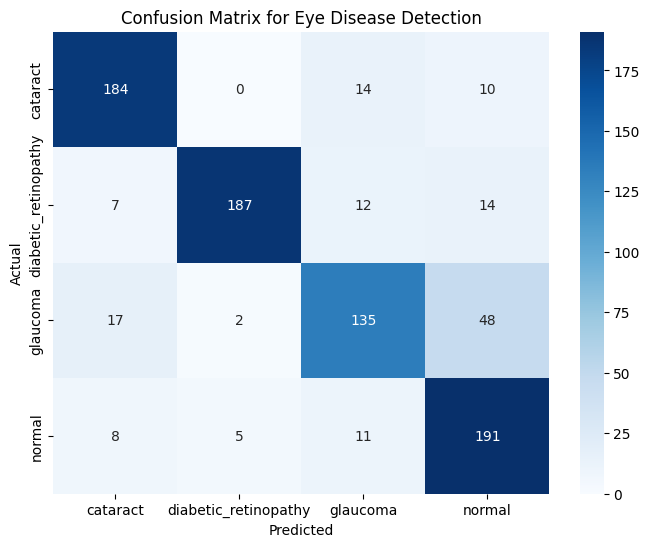

In [27]:
# --- Step 3: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Eye Disease Detection')
plt.show()

In [28]:
# --- Step 4: Precision, Recall, F1 ---
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

Classification Report:

                      precision    recall  f1-score   support

            cataract       0.85      0.88      0.87       208
diabetic_retinopathy       0.96      0.85      0.90       220
            glaucoma       0.78      0.67      0.72       202
              normal       0.73      0.89      0.80       215

            accuracy                           0.82       845
           macro avg       0.83      0.82      0.82       845
        weighted avg       0.83      0.82      0.82       845

Weighted Precision: 0.8331
Weighted Recall: 0.8249
Weighted F1-Score: 0.8248


In [30]:
with open("model_metrics.txt", "w") as f:
    f.write("Eye Disease Detection Model Metrics\n")
    f.write("=================================\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n\n")
    f.write("Detailed Report:\n")
    f.write(classification_report(y_true, y_pred_classes, target_names=class_labels))
print("📁 Metrics saved as model_metrics.txt")



📁 Metrics saved as model_metrics.txt


In [31]:
from google.colab import files
files.download("model_metrics.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>